<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 20 11:09:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   30C    P0    27W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
def train_model(convert_color, original=False, preprocess=False):
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.xception.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.xception.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
83697664/83683744 [==============================] - 65s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 21s 39ms/step - loss: 0.6038 - accuracy: 0.7400 - val_loss: 0.5081 - val_accuracy: 0.7775
Epoch 2/100
360/360 [==============================] - 17s 46ms/step - loss: 0.5267 - accuracy: 0.7746 - val_loss: 0.5091 - val_accuracy: 0.7767
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5041 - accuracy: 0.7816 - val_loss: 0.4745 - val_accuracy: 0.7968
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4949 - accuracy: 0.7867 - val_loss: 0.4675 - val_accuracy: 0.8046
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4827 - accuracy: 0.7921 - val_loss: 0.4794 - val_accuracy: 0.7871
Epoch 6/100
360/360

Epoch 54/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3768 - accuracy: 0.8403 - val_loss: 0.3916 - val_accuracy: 0.8378
Epoch 55/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3719 - accuracy: 0.8447 - val_loss: 0.4040 - val_accuracy: 0.8366
Epoch 56/100
360/360 [==============================] - 12s 33ms/step - loss: 0.3767 - accuracy: 0.8418 - val_loss: 0.4008 - val_accuracy: 0.8345
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3728 - accuracy: 0.8465 - val_loss: 0.3947 - val_accuracy: 0.8399
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3726 - accuracy: 0.8431 - val_loss: 0.4001 - val_accuracy: 0.8357
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3697 - accuracy: 0.8448 - val_loss: 0.3991 - val_accuracy: 0.8374
Epoch 60/100
360/360 [==============================] - 12s 33ms/step - loss: 0.3684 - accuracy: 0.8484 - val_loss: 0.4034 -

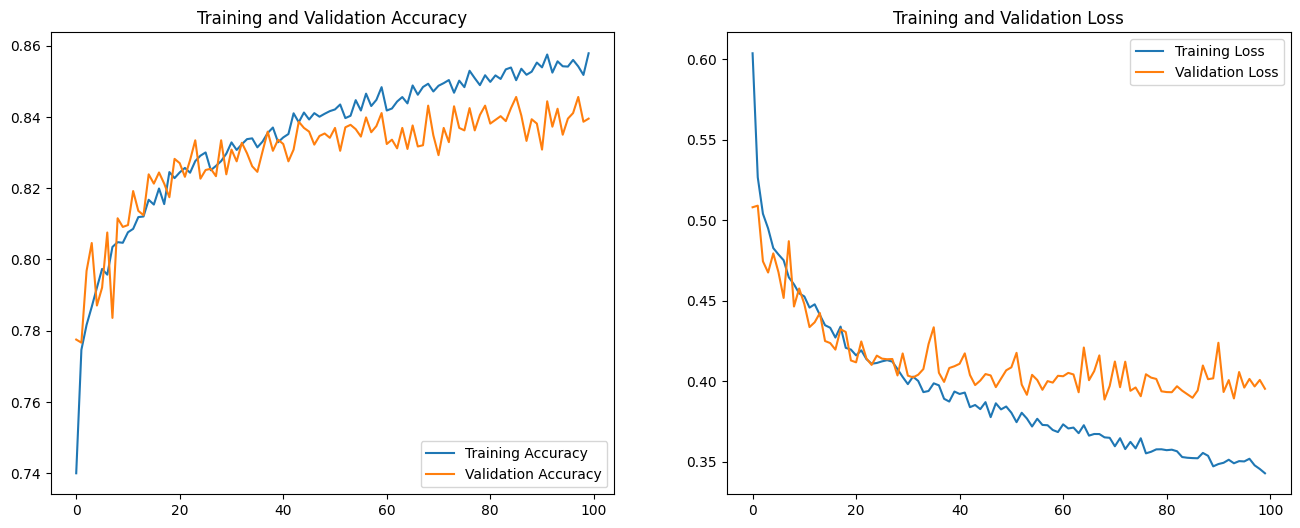

In [4]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 17s 38ms/step - loss: 0.6099 - accuracy: 0.7434 - val_loss: 0.5206 - val_accuracy: 0.7860
Epoch 2/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5337 - accuracy: 0.7708 - val_loss: 0.4731 - val_accuracy: 0.8011
Epoch 3/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5082 - accuracy: 0.7843 - val_loss: 0.4730 - val_accuracy: 0.8055
Epoch 4/100
360/360 [==============================] - 12s 35ms/step - loss: 0.4947 - accuracy: 0.7904 - val_loss: 0.4895 - val_accuracy: 0.7989
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4962 - accuracy: 0.7908 - val_loss: 0.4684 - val_accuracy: 0.7966
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3744 - accuracy: 0.8458 - val_loss: 0.3948 - val_accuracy: 0.8439
Epoch 57/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3655 - accuracy: 0.8499 - val_loss: 0.4035 - val_accuracy: 0.8402
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3664 - accuracy: 0.8494 - val_loss: 0.4000 - val_accuracy: 0.8463
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3619 - accuracy: 0.8500 - val_loss: 0.4023 - val_accuracy: 0.8394
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3624 - accuracy: 0.8497 - val_loss: 0.4035 - val_accuracy: 0.8433
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3641 - accuracy: 0.8504 - val_loss: 0.3919 - val_accuracy: 0.8458
Epoch 62/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3657 - accuracy: 0.8457 - val_loss: 0.4012 -

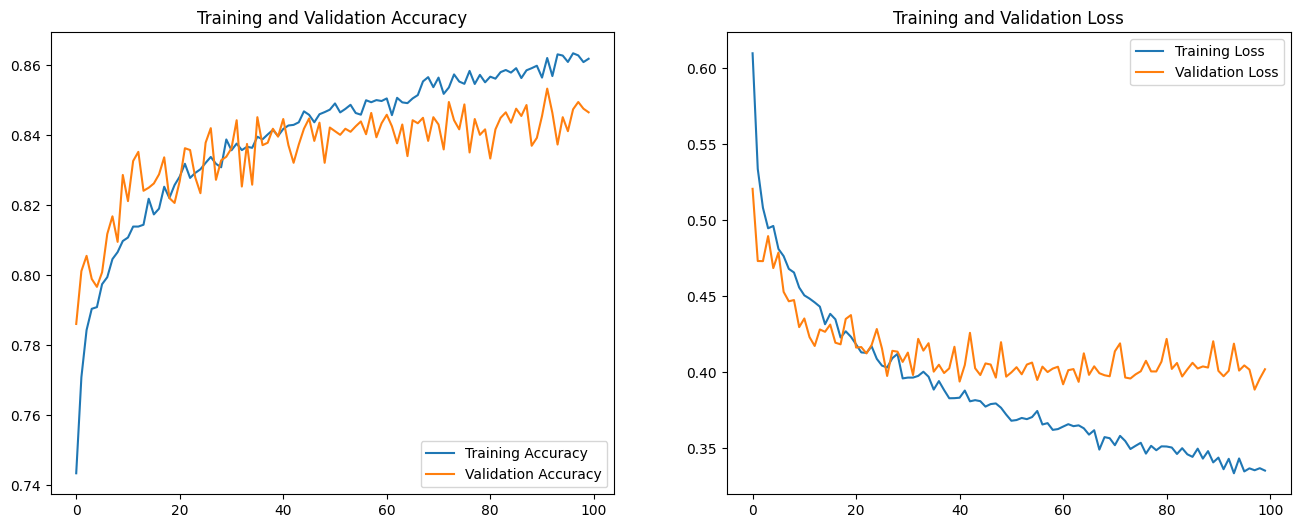

In [5]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 38ms/step - loss: 1.2054 - accuracy: 0.5476 - val_loss: 0.8904 - val_accuracy: 0.6138
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 0.8793 - accuracy: 0.6300 - val_loss: 0.8513 - val_accuracy: 0.6355
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 0.8175 - accuracy: 0.6582 - val_loss: 0.7430 - val_accuracy: 0.6921
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 0.7799 - accuracy: 0.6783 - val_loss: 0.7900 - val_accuracy: 0.6763
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.7470 - accuracy: 0.6960 - val_loss: 0.6879 - val_accuracy: 0.7063
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 0.7350 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5608 - accuracy: 0.7792 - val_loss: 0.5246 - val_accuracy: 0.7911
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5561 - accuracy: 0.7826 - val_loss: 0.5385 - val_accuracy: 0.7850
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 0.5638 - accuracy: 0.7779 - val_loss: 0.5299 - val_accuracy: 0.7895
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 0.5575 - accuracy: 0.7806 - val_loss: 0.5252 - val_accuracy: 0.7820
Epoch 60/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5604 - accuracy: 0.7792 - val_loss: 0.5492 - val_accuracy: 0.7761
Epoch 61/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5526 - accuracy: 0.7828 - val_loss: 0.5760 - val_accuracy: 0.7629
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5554 - accuracy: 0.7813 - val_loss: 0.5305 -

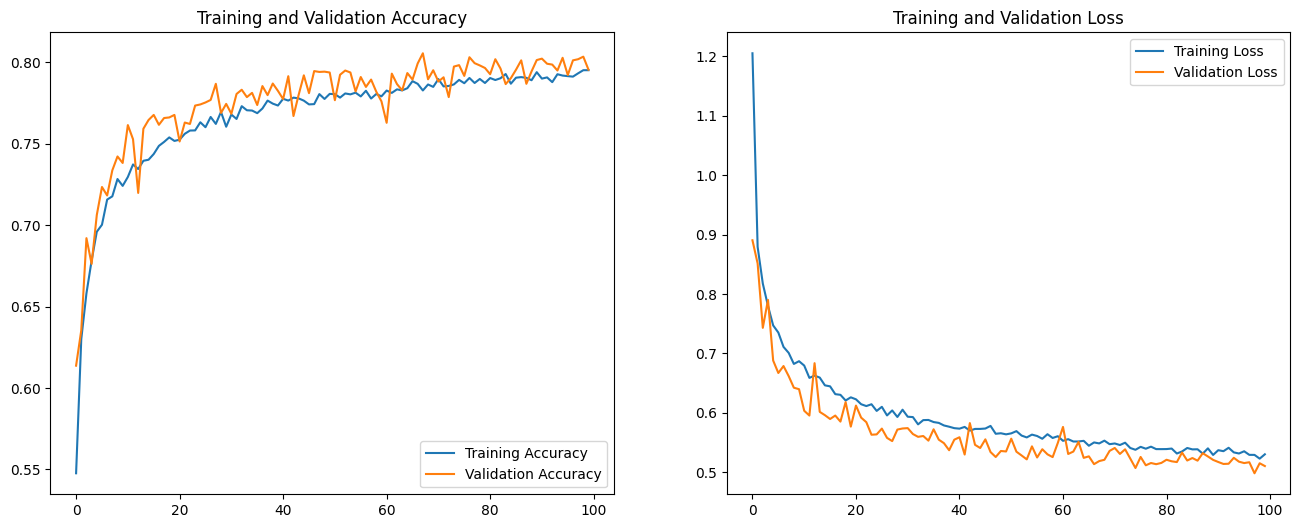

In [6]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 17s 36ms/step - loss: 1.4245 - accuracy: 0.3008 - val_loss: 1.3984 - val_accuracy: 0.3989
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 1.3867 - accuracy: 0.3524 - val_loss: 1.3179 - val_accuracy: 0.4189
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 1.3243 - accuracy: 0.3939 - val_loss: 1.2520 - val_accuracy: 0.4397
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2933 - accuracy: 0.4084 - val_loss: 1.2282 - val_accuracy: 0.4364
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 1.2761 - accuracy: 0.4218 - val_loss: 1.3550 - val_accuracy: 0.3463
Epoch 6/100
360/360 [==============================] - 12s 35ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1083 - accuracy: 0.5151 - val_loss: 1.0065 - val_accuracy: 0.5658
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1057 - accuracy: 0.5146 - val_loss: 1.0131 - val_accuracy: 0.5683
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 1.1101 - accuracy: 0.5109 - val_loss: 1.0508 - val_accuracy: 0.5412
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1056 - accuracy: 0.5153 - val_loss: 1.0310 - val_accuracy: 0.5573
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1063 - accuracy: 0.5146 - val_loss: 1.0143 - val_accuracy: 0.5757
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1088 - accuracy: 0.5116 - val_loss: 1.0223 - val_accuracy: 0.5660
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0959 - accuracy: 0.5189 - val_loss: 1.0820 -

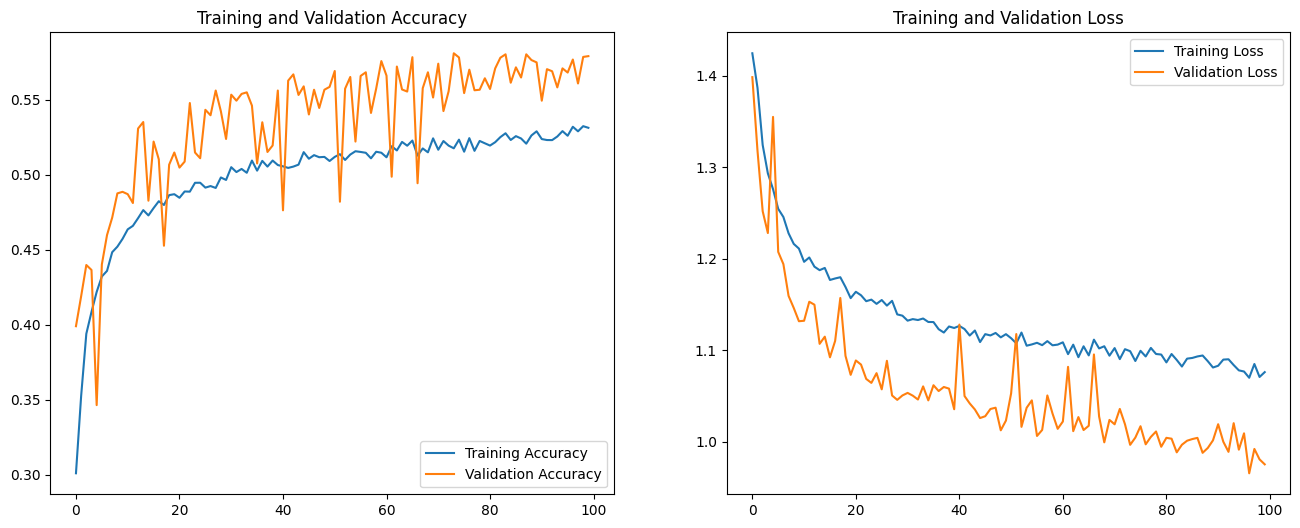

In [7]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 37ms/step - loss: 0.5361 - accuracy: 0.7859 - val_loss: 0.4517 - val_accuracy: 0.8190
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4338 - accuracy: 0.8232 - val_loss: 0.4074 - val_accuracy: 0.8383
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4222 - accuracy: 0.8273 - val_loss: 0.3842 - val_accuracy: 0.8499
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4025 - accuracy: 0.8355 - val_loss: 0.3848 - val_accuracy: 0.8475
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3924 - accuracy: 0.8400 - val_loss: 0.4037 - val_accuracy: 0.8366
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3834 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2679 - accuracy: 0.8941 - val_loss: 0.3151 - val_accuracy: 0.8795
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2662 - accuracy: 0.8936 - val_loss: 0.3201 - val_accuracy: 0.8805
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2615 - accuracy: 0.8970 - val_loss: 0.3085 - val_accuracy: 0.8852
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2629 - accuracy: 0.8970 - val_loss: 0.3117 - val_accuracy: 0.8793
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2650 - accuracy: 0.8946 - val_loss: 0.3237 - val_accuracy: 0.8783
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2640 - accuracy: 0.8956 - val_loss: 0.3025 - val_accuracy: 0.8854
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2609 - accuracy: 0.8949 - val_loss: 0.3161 -

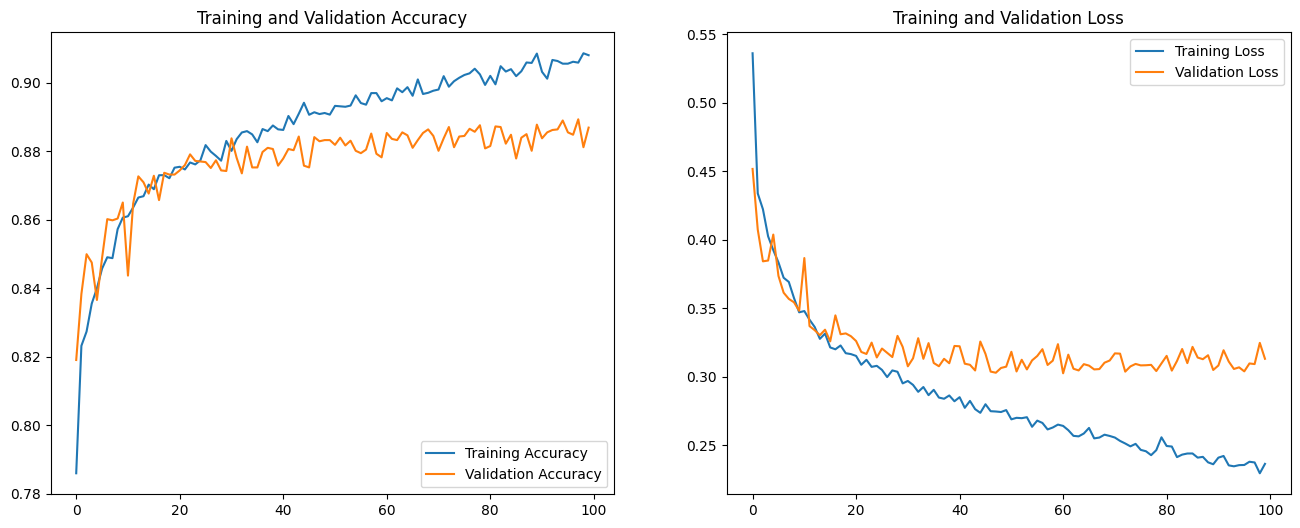

In [8]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 35ms/step - loss: 1.2922 - accuracy: 0.4069 - val_loss: 1.1713 - val_accuracy: 0.4705
Epoch 2/100
360/360 [==============================] - 12s 33ms/step - loss: 1.2013 - accuracy: 0.4533 - val_loss: 1.1694 - val_accuracy: 0.4608
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1836 - accuracy: 0.4659 - val_loss: 1.1528 - val_accuracy: 0.4821
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1674 - accuracy: 0.4708 - val_loss: 1.1617 - val_accuracy: 0.4793
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1577 - accuracy: 0.4793 - val_loss: 1.1199 - val_accuracy: 0.5177
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0917 - accuracy: 0.5186 - val_loss: 1.0499 - val_accuracy: 0.5394
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0938 - accuracy: 0.5146 - val_loss: 1.0436 - val_accuracy: 0.5337
Epoch 58/100
360/360 [==============================] - 12s 33ms/step - loss: 1.0912 - accuracy: 0.5170 - val_loss: 1.0551 - val_accuracy: 0.5389
Epoch 59/100
360/360 [==============================] - 12s 33ms/step - loss: 1.0915 - accuracy: 0.5199 - val_loss: 1.0578 - val_accuracy: 0.5403
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0929 - accuracy: 0.5173 - val_loss: 1.0365 - val_accuracy: 0.5452
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0884 - accuracy: 0.5209 - val_loss: 1.0372 - val_accuracy: 0.5448
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0895 - accuracy: 0.5199 - val_loss: 1.0348 -

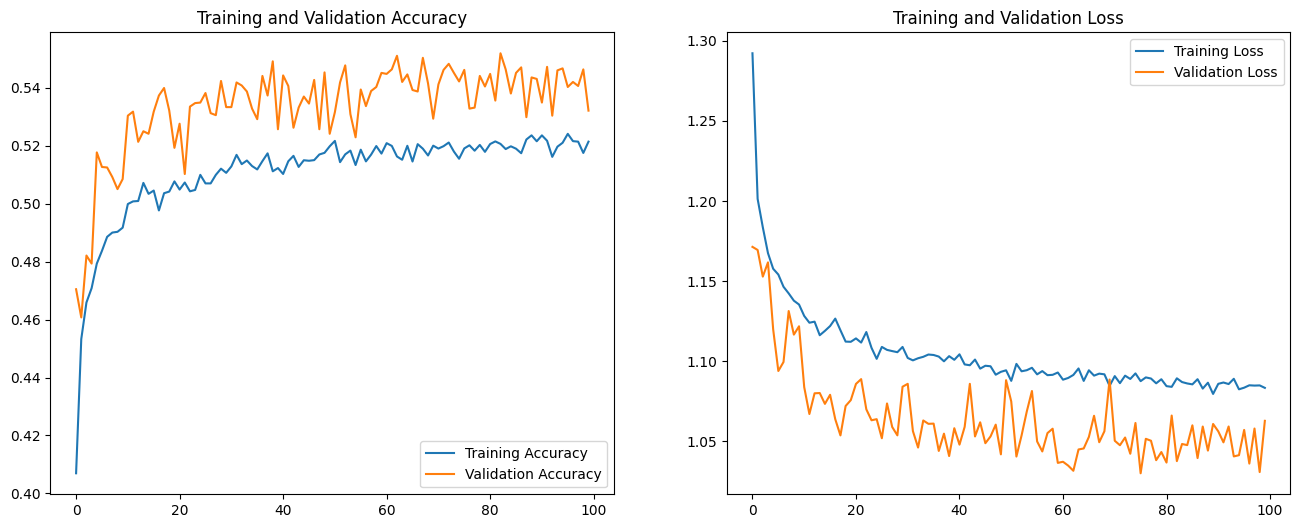

In [9]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 37ms/step - loss: 0.8936 - accuracy: 0.6205 - val_loss: 0.8034 - val_accuracy: 0.6395
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 0.7953 - accuracy: 0.6531 - val_loss: 0.7689 - val_accuracy: 0.6594
Epoch 3/100
360/360 [==============================] - 12s 33ms/step - loss: 0.7733 - accuracy: 0.6649 - val_loss: 0.7468 - val_accuracy: 0.6702
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.7598 - accuracy: 0.6728 - val_loss: 0.7466 - val_accuracy: 0.6695
Epoch 5/100
360/360 [==============================] - 12s 35ms/step - loss: 0.7503 - accuracy: 0.6744 - val_loss: 0.7655 - val_accuracy: 0.6591
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 0.7381 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6353 - accuracy: 0.7282 - val_loss: 0.6664 - val_accuracy: 0.7171
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6362 - accuracy: 0.7255 - val_loss: 0.6766 - val_accuracy: 0.7093
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6394 - accuracy: 0.7235 - val_loss: 0.6725 - val_accuracy: 0.7114
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6378 - accuracy: 0.7268 - val_loss: 0.6720 - val_accuracy: 0.7086
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6284 - accuracy: 0.7338 - val_loss: 0.6690 - val_accuracy: 0.7173
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6307 - accuracy: 0.7311 - val_loss: 0.6708 - val_accuracy: 0.7124
Epoch 62/100
360/360 [==============================] - 12s 33ms/step - loss: 0.6357 - accuracy: 0.7260 - val_loss: 0.6796 -

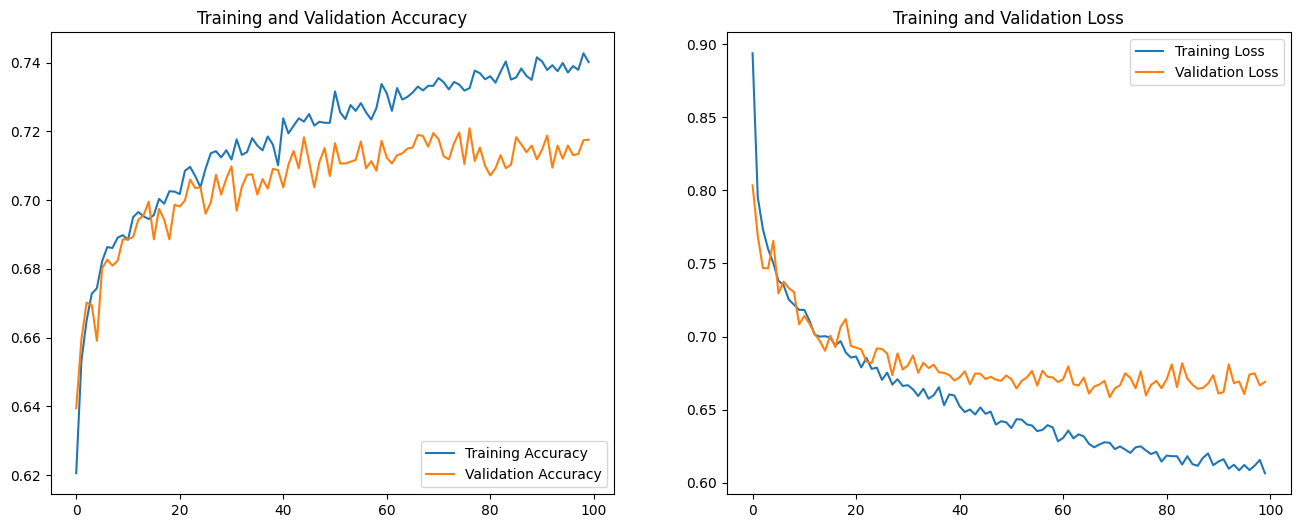

In [10]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 36ms/step - loss: 1.4255 - accuracy: 0.2872 - val_loss: 1.4065 - val_accuracy: 0.2906
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 1.4152 - accuracy: 0.3036 - val_loss: 1.3938 - val_accuracy: 0.3399
Epoch 3/100
360/360 [==============================] - 12s 33ms/step - loss: 1.3969 - accuracy: 0.3133 - val_loss: 1.3382 - val_accuracy: 0.3595
Epoch 4/100
360/360 [==============================] - 12s 33ms/step - loss: 1.3519 - accuracy: 0.3582 - val_loss: 1.2795 - val_accuracy: 0.3753
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.3200 - accuracy: 0.3770 - val_loss: 1.2829 - val_accuracy: 0.4281
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1741 - accuracy: 0.4720 - val_loss: 1.1128 - val_accuracy: 0.5005
Epoch 57/100
360/360 [==============================] - 12s 35ms/step - loss: 1.1617 - accuracy: 0.4789 - val_loss: 1.0754 - val_accuracy: 0.5281
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1597 - accuracy: 0.4823 - val_loss: 1.0523 - val_accuracy: 0.5481
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1607 - accuracy: 0.4758 - val_loss: 1.0495 - val_accuracy: 0.5630
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1543 - accuracy: 0.4793 - val_loss: 1.0415 - val_accuracy: 0.5584
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1704 - accuracy: 0.4699 - val_loss: 1.0531 - val_accuracy: 0.5531
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1611 - accuracy: 0.4744 - val_loss: 1.0594 -

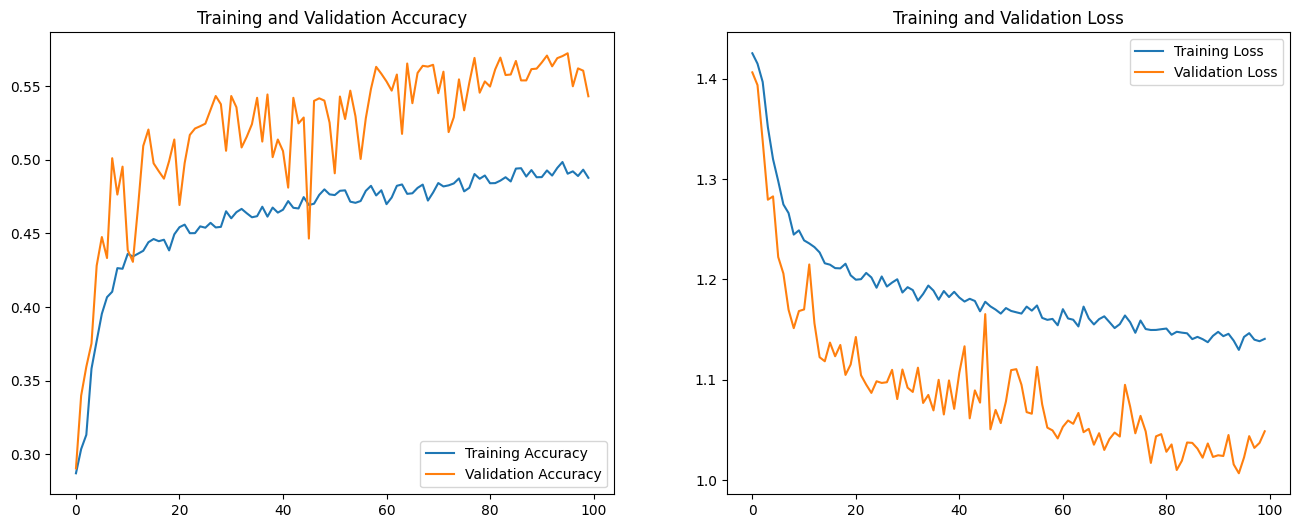

In [11]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 36ms/step - loss: 0.5638 - accuracy: 0.7677 - val_loss: 0.4691 - val_accuracy: 0.8069
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4776 - accuracy: 0.8020 - val_loss: 0.4464 - val_accuracy: 0.8270
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4593 - accuracy: 0.8089 - val_loss: 0.4165 - val_accuracy: 0.8307
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4336 - accuracy: 0.8192 - val_loss: 0.3969 - val_accuracy: 0.8369
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4263 - accuracy: 0.8235 - val_loss: 0.4620 - val_accuracy: 0.8057
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4156 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3189 - accuracy: 0.8732 - val_loss: 0.3298 - val_accuracy: 0.8737
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3134 - accuracy: 0.8738 - val_loss: 0.3263 - val_accuracy: 0.8739
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3147 - accuracy: 0.8740 - val_loss: 0.3299 - val_accuracy: 0.8701
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3190 - accuracy: 0.8730 - val_loss: 0.3484 - val_accuracy: 0.8677
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3133 - accuracy: 0.8751 - val_loss: 0.3280 - val_accuracy: 0.8776
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3154 - accuracy: 0.8747 - val_loss: 0.3240 - val_accuracy: 0.8769
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3087 - accuracy: 0.8782 - val_loss: 0.3230 -

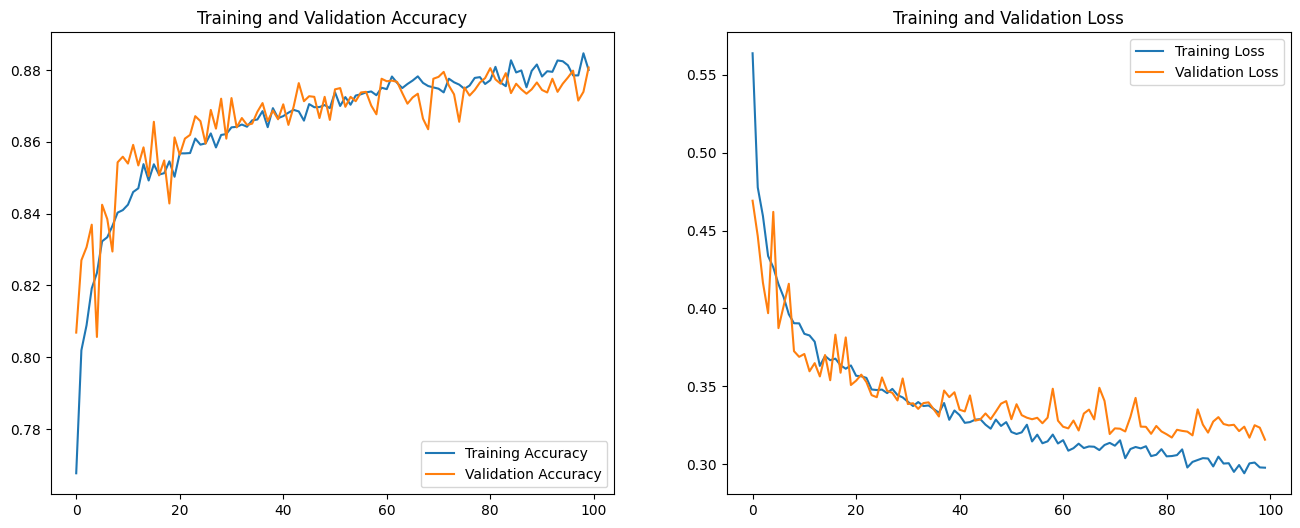

In [12]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 17s 36ms/step - loss: 1.4186 - accuracy: 0.2968 - val_loss: 1.3912 - val_accuracy: 0.2756
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 1.3569 - accuracy: 0.3527 - val_loss: 1.2474 - val_accuracy: 0.4981
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.2580 - accuracy: 0.4165 - val_loss: 1.1527 - val_accuracy: 0.5212
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1975 - accuracy: 0.4563 - val_loss: 1.1230 - val_accuracy: 0.5184
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1814 - accuracy: 0.4683 - val_loss: 1.0918 - val_accuracy: 0.5264
Epoch 6/100
360/360 [==============================] - 12s 35ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0462 - accuracy: 0.5368 - val_loss: 0.9775 - val_accuracy: 0.5834
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0404 - accuracy: 0.5441 - val_loss: 0.9500 - val_accuracy: 0.5886
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0477 - accuracy: 0.5415 - val_loss: 0.9447 - val_accuracy: 0.5830
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0447 - accuracy: 0.5385 - val_loss: 1.0016 - val_accuracy: 0.5630
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0371 - accuracy: 0.5408 - val_loss: 0.9360 - val_accuracy: 0.5919
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0481 - accuracy: 0.5354 - val_loss: 0.9919 - val_accuracy: 0.5726
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0515 - accuracy: 0.5340 - val_loss: 0.9462 -

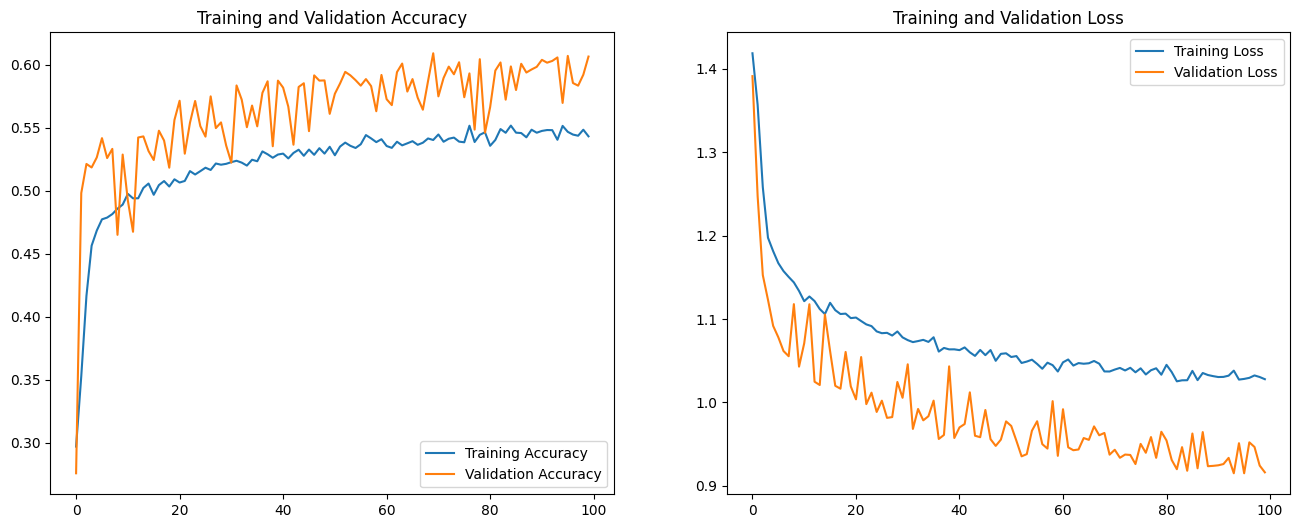

In [13]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 37ms/step - loss: 0.6195 - accuracy: 0.7376 - val_loss: 0.5222 - val_accuracy: 0.7869
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5367 - accuracy: 0.7751 - val_loss: 0.5026 - val_accuracy: 0.7919
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5176 - accuracy: 0.7852 - val_loss: 0.4976 - val_accuracy: 0.7883
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5102 - accuracy: 0.7863 - val_loss: 0.4703 - val_accuracy: 0.8084
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4893 - accuracy: 0.7946 - val_loss: 0.4637 - val_accuracy: 0.8072
Epoch 6/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4897 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3866 - accuracy: 0.8421 - val_loss: 0.3982 - val_accuracy: 0.8404
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3782 - accuracy: 0.8452 - val_loss: 0.4007 - val_accuracy: 0.8361
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3800 - accuracy: 0.8448 - val_loss: 0.3954 - val_accuracy: 0.8374
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3759 - accuracy: 0.8488 - val_loss: 0.3950 - val_accuracy: 0.8409
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3809 - accuracy: 0.8441 - val_loss: 0.3923 - val_accuracy: 0.8449
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3795 - accuracy: 0.8463 - val_loss: 0.3966 - val_accuracy: 0.8367
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3802 - accuracy: 0.8457 - val_loss: 0.3925 -

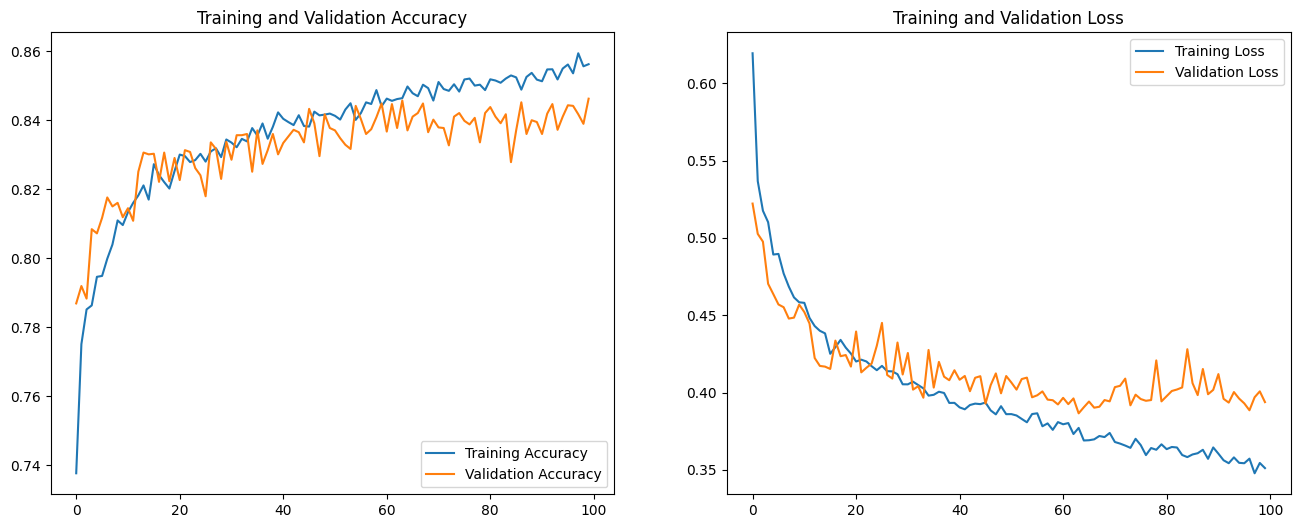

In [14]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
# !mkdir xception_nontrainable
# pd.DataFrame(res_rgb).to_csv("xception_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("xception_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("xception_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("xception_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("xception_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("xception_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("xception_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("xception_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("xception_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("xception_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("xception_nontrainable/res_ydbdr_nonpre.csv", index=False)